---
# Install the required packages

If needed install the following packages:

In [42]:
# !pip install tensorflow keras

---
# Imports

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, Input
from tensorflow.keras.layers import LSTM

---
# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of **R peak interval** for a patient. Your task involves employing deep learning methods to forecast the **required measurements**. To accomplish this you will be using a patient's ECG measurements from the MITDB database, which consists of the following values:

- R peak Interval (int: the time the R peak appeared)
- Beat Annotation (string: the beat type)
- Episode Annotation (string: the episode type)

**Note: You are required to perform this laboratory assignment on your local machine.**


# Read the data

You are required to load the given data from the `201_cleaned.ann` file (csv format). Load the data into a `pandas dataframe` and display the first 5 rows of the dataframe.

In [32]:
data = pd.read_csv('201_cleaned.ann')

In [6]:
data.head()

,R peak Interval,Beat Annotation,Episode Annotation
0,55,N,(AFIB
1,144,N,(AFIB
2,238,N,(AFIB
3,314,N,(AFIB
4,412,N,(AFIB


---
# EDA

## Explore the Beat Annotation Distribution

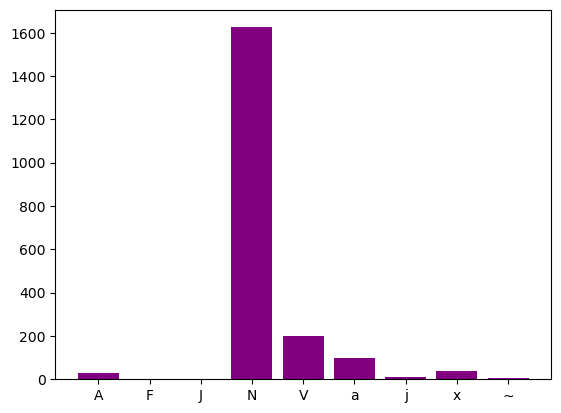

In [14]:
beat_counts = data.groupby('Beat Annotation').size()
plt.bar(beat_counts.index, beat_counts, color='purple')
plt.show()

## Explore the Episode Annotation Distribution

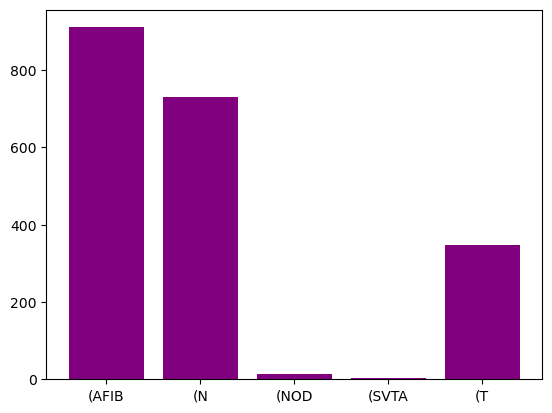

In [16]:
episode_counts = data.groupby('Episode Annotation').size()
plt.bar(episode_counts.index, episode_counts, color='purple')
plt.show()

---
# Feature Engineering

## Re-Labeling the data (Beat Annotation)

Re-label the data into 3 beat types:
- Normal Beat (N)
- Ventricular Beat (V)
- Other Beats (Other)

In [34]:
data['Beat Annotation'] = data['Beat Annotation'].map(lambda x: x if x in ['N', 'V'] else 'Other')

Check that the mapping worked:

In [37]:
data['Beat Annotation'].value_counts()

Beat Annotation
N        1625
V         198
Other     181
Name: count, dtype: int64

## Re-Labeling the data (Episode Annotation)

Re-label the data into 3 beat types:
- Normal Episode: (N
- Atrial Fibrillation: (AFIB
- Other Episode: (Other

In [39]:
data['Episode Annotation'] = data['Episode Annotation'].map(lambda x: x if x in ['(N', '(AFIB'] else 'Other')

Check that the mapping worked:

In [42]:
data['Episode Annotation'].value_counts()

Episode Annotation
(AFIB    911
(N       730
Other    363
Name: count, dtype: int64

## Create Lag Features (5 prev values) for R peak Interval measurement

Apply a lag for the R peak Interval, creating a set of features representing the historical patient data. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [44]:
for i in range(1,6):
    data[f'R_lag{i}'] = data['R peak Interval'].shift(i)

In [48]:
data.dropna(axis=0, inplace=True)

Check that the mapping worked:

In [51]:
data.head()

,R peak Interval,Beat Annotation,Episode Annotation,R_lag1,R_lag2,R_lag3,R_lag4,R_lag5
5,493,N,(AFIB,412.0,314.0,238.0,144.0,55.0
6,562,N,(AFIB,493.0,412.0,314.0,238.0,144.0
7,682,N,(AFIB,562.0,493.0,412.0,314.0,238.0
8,776,N,(AFIB,682.0,562.0,493.0,412.0,314.0
9,866,N,(AFIB,776.0,682.0,562.0,493.0,412.0


## Generate R-R interval features


For the past 5 R peak intervals ($R_{i}, i \in \{-1, -2, -3, -4, -5\}$), generate the 4 R-R intervals as features.

$RR_{i} = R_{i} - R_{i-1}$

In [55]:
for i in range(1,5):
    data[f'RR {i}'] = data[f'R_lag{i}'] - data[f'R_lag{i+1}']

Additionally, generate the current R-R Interval, which we will be using as a target.  

$RR_{curr} = (R_{0} - R_{-1})$

In [59]:
data['RR'] = data['R peak Interval'] = data['R_lag1']

Check that the mapping worked:

In [61]:
data.head()

,R peak Interval,Beat Annotation,Episode Annotation,R_lag1,R_lag2,R_lag3,R_lag4,R_lag5,RR 1,RR 2,RR 3,RR 4,RR
5,412.0,N,(AFIB,412.0,314.0,238.0,144.0,55.0,98.0,76.0,94.0,89.0,412.0
6,493.0,N,(AFIB,493.0,412.0,314.0,238.0,144.0,81.0,98.0,76.0,94.0,493.0
7,562.0,N,(AFIB,562.0,493.0,412.0,314.0,238.0,69.0,81.0,98.0,76.0,562.0
8,682.0,N,(AFIB,682.0,562.0,493.0,412.0,314.0,120.0,69.0,81.0,98.0,682.0
9,776.0,N,(AFIB,776.0,682.0,562.0,493.0,412.0,94.0,120.0,69.0,81.0,776.0


## Encode the categorical variables

In [73]:
def encode(data, columns):
    enc = LabelEncoder()
    for column in columns:
        enc_values = enc.fit_transform(data[column])
        data[column] = enc_values

In [75]:
encode(data, ['Beat Annotation', 'Episode Annotation'])

Check that the mapping worked:

In [77]:
data.head()

,R peak Interval,Beat Annotation,Episode Annotation,R_lag1,R_lag2,R_lag3,R_lag4,R_lag5,RR 1,RR 2,RR 3,RR 4,RR
5,412.0,0,0,412.0,314.0,238.0,144.0,55.0,98.0,76.0,94.0,89.0,412.0
6,493.0,0,0,493.0,412.0,314.0,238.0,144.0,81.0,98.0,76.0,94.0,493.0
7,562.0,0,0,562.0,493.0,412.0,314.0,238.0,69.0,81.0,98.0,76.0,562.0
8,682.0,0,0,682.0,562.0,493.0,412.0,314.0,120.0,69.0,81.0,98.0,682.0
9,776.0,0,0,776.0,682.0,562.0,493.0,412.0,94.0,120.0,69.0,81.0,776.0


---
# Model Training

## Remove unnecessary columns

For the purposes of training we will only be using the following columns as features:
- Beat Annotation
- Episode Annotation
- **All historical** 4 RR intervals

Moreover, the target column we will be forcasting is the ```current RR``` interval.

In [85]:
data.drop(columns=[f'R_lag{i}' for i in range(1,6)], inplace=True)

In [89]:
data.drop('R peak Interval', axis=1, inplace=True)

In [91]:
data.head()

,Beat Annotation,Episode Annotation,RR 1,RR 2,RR 3,RR 4,RR
5,0,0,98.0,76.0,94.0,89.0,412.0
6,0,0,81.0,98.0,76.0,94.0,493.0
7,0,0,69.0,81.0,98.0,76.0,562.0
8,0,0,120.0,69.0,81.0,98.0,682.0
9,0,0,94.0,120.0,69.0,81.0,776.0


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**

In [95]:
from sklearn.model_selection import train_test_split

X = data.drop('RR', axis=1)
Y = data['RR']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

## Neural Network (RNN / CRNN)

Create a deep (convolutional) recurrent neural network using:
- Minimum of 1 Convolutional Layer **(+2 points Optional)** and
- Minimum of 1 LSTM Layer

**Reshape Data If Necessary**

Compile and fit the model (Run only train 3 Epoch).

---
# Model Evaluation

Use the trained model to make predictions for the test set.

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.